In [4]:
import os
import re
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import seaborn as sns
from matplotlib.pyplot import rc_context
from tqdm.notebook import tqdm, trange
from sklearn.preprocessing import MinMaxScaler
sc.settings.verbosity = 3

In [5]:
p_dir = (Path().cwd().parents[0]).absolute()
data_dir = p_dir / "data"

In [6]:
%load_ext autoreload
%autoreload 2

module_path = str(p_dir / "src")

if module_path not in sys.path:
    sys.path.append(module_path)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import scSpaMet as spamet

In [8]:
experiment = "tonsil"
cores = ["DonorA", "DonorE"]
datasets = [core + f"_{i}" for i in range(1, 7) for core in cores]

# Load data

In [9]:
def read_props(dataset, experiment):
    df_morph = pd.read_csv(data_dir / "props" / f"morphology_IMC_{experiment}_{dataset}.csv")
    df_intensity_IMC = pd.read_csv(data_dir / "props" / f"intensity_IMC_{experiment}_{dataset}.csv")
    df_intensity_TS = pd.read_csv(data_dir / "props" / f"intensity_TS_{experiment}_{dataset}_auto.csv")

    return df_morph, df_intensity_IMC, df_intensity_TS

In [10]:
%%capture 

adatas = []
adatas_raw = []
df_sums = []
for dataset in datasets:
    try:
        df_morph, df_intensity_IMC, df_intensity_TS = read_props(dataset, experiment)
        print(f'Sucessfully read dataset {dataset}') 
    except:
        print(f'{dataset} cannot be read') 
        continue
    try:
        df_intensity_TS.drop(['Rest', 'Total'], axis=1, inplace=True)
    except:
        pass
    df_intensity_TS.iloc[:, 1:] = df_intensity_TS.iloc[:, 1:].multiply(
        df_morph["area"], axis=0
    )
    # data_all = df_intensity_TS.iloc[:, 1:].values
    # data_all_norm = (data_all+0.1)/(np.percentile(data_all,50,axis=1,keepdims=True)+0.1)
    # data_all_norm = MinMaxScaler().fit_transform(data_all)
    # df_intensity_TS.iloc[:, 1:] = data_all_norm
    
    # Merge TS and IMC data
    df = df_intensity_TS
    df.set_index("Id", inplace=True)
    df_sums.append(df.sum(axis=0))
    
    # Put to adata format
    adata = sc.AnnData(df.values)
    adata.var_names = df.columns.tolist()
    adata.obs["Cell"] = df.index.tolist()
    adata.obs["Dataset"] = dataset
    adata.obs["Core"] = dataset.split("_")[0]
    adata.obsm["spatial"] = df_morph[["centroid-0", "centroid-1"]].to_numpy()
    
    # FPM normalize
    sc.pp.normalize_total(adata, target_sum=1e5)
    # sc.pp.log1p(adata, base=2)
    adatas_raw.append(adata.copy())
    
    # Standard scale
    sc.pp.scale(adata)
    adatas.append(adata)
    
adata = ad.concat(adatas, join="inner")
adata_raw = ad.concat(adatas_raw, join="inner")

normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)


In [11]:
# Read Protein clustering info
path = data_dir / "adata" / f"{experiment}.h5ad"
adata_IMC_cluster = ad.read_h5ad(path)


C:\Users\thu71\Anaconda3\envs\scanpy\Lib\site-packages\anndata\_core\anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [12]:
adata = adata[~adata.obs.Dataset.isin(['F7_1', 'F7_2'])]
adata_IMC = adata_IMC_cluster[~adata_IMC_cluster.obs.Dataset.isin(['F7_1', 'F7_2'])]

In [13]:
df_sum = pd.concat(df_sums, axis=1).mean(axis=1)
# mz_qc = df_sum[(df_sum > 16000)].index.tolist()
mz_qc = df_sum[(df_sum > 220)].index.tolist()

In [14]:
len(mz_qc)

197

In [15]:
adata = adata[:, mz_qc]
adata_raw = adata_raw[:, mz_qc]

In [16]:
# Define IMC and SIMS marker list
IMC_markers = adata.var_names.tolist()
SIMS_masses = adata_IMC.var_names.tolist()

# Joint embedding

In [14]:
def Umap(a,rep=None):
    if rep is not None:
        print(f'Using representation {rep}')
        sc.pp.neighbors(a,use_rep=rep, metric='cosine')
    else:
        sc.pp.neighbors(a)
    sc.tl.umap(a)
    print('Sucessfully run Umap!')
    return a

def TSNE(a,rep=None):
    if rep is not None:
        print(f'Using representation {rep}')
        sc.tl.tsne(a,use_rep=rep)
    else:
        sc.tl.tsne(a)
    print('Sucessfully run TSNE!')
    return a

In [15]:
train_x_IMC = adata_IMC.X
train_x_SIMS = adata.X

In [16]:
train_x_IMC.shape

(19507, 12)

In [17]:
train_x_SIMS.shape

(19507, 197)

In [18]:
# X_embedding, _, _ = spamet.tl.Joint_XVAE_clustering(train_x_IMC, train_x_SIMS, epochs=20)
# X_embedding, q, X_predict = spamet.tl.Joint_XVAE_clustering(train_x_IMC, train_x_SIMS, epochs=50, resolution=0.3, latent_dim=16, netwidths_1=[16,8,8], netwidths_2=[128,64,32,16])

GPU name:  []


C:\Users\thu71\Anaconda3\envs\scanpy\Lib\site-packages\keras\initializers\initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Epoch 1/50
610/610 - 4s - loss: 0.5149 - reconstruction_loss: 0.5075 - kl_loss: 0.7336 - 4s/epoch - 7ms/step
Epoch 2/50
610/610 - 1s - loss: 0.4165 - reconstruction_loss: 0.4115 - kl_loss: 0.4944 - 1s/epoch - 2ms/step
Epoch 3/50
610/610 - 1s - loss: 0.3747 - reconstruction_loss: 0.3688 - kl_loss: 0.5907 - 1s/epoch - 2ms/step
Epoch 4/50
610/610 - 1s - loss: 0.3456 - reconstruction_loss: 0.3389 - kl_loss: 0.6705 - 1s/epoch - 2ms/step
Epoch 5/50
610/610 - 1s - loss: 0.3282 - reconstruction_loss: 0.3210 - kl_loss: 0.7242 - 1s/epoch - 2ms/step
Epoch 6/50
610/610 - 1s - loss: 0.3185 - reconstruction_loss: 0.3110 - kl_loss: 0.7475 - 1s/epoch - 2ms/step
Epoch 7/50
610/610 - 1s - loss: 0.3114 - reconstruction_loss: 0.3037 - kl_loss: 0.7682 - 1s/epoch - 2ms/step
Epoch 8/50
610/610 - 1s - loss: 0.3050 - reconstruction_loss: 0.2970 - kl_loss: 0.8015 - 1s/epoch - 2ms/step
Epoch 9/50
610/610 - 1s - loss: 0.3001 - reconstruction_loss: 0.2919 - kl_loss: 0.8214 - 1s/epoch - 2ms/step
Epoch 10/50
610/610

C:\Users\thu71\Anaconda3\envs\scanpy\Lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\thu71\Anaconda3\envs\scanpy\Lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\thu71\Anaconda3\envs\scanpy\Lib\site-packages\umap\distances.py:1086: NumbaDepr

    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:20)
running Leiden clustering
    finished: found 6 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:02)
The value of delta_label of current 1 th iteration is 0.16019890295791253 >= tol 0.005
Epoch 1/50
610/610 [==============================] - 2s 2ms/step - loss: 0.0678
Epoch 2/50
610/610 [==============================] - 1s 2ms/step - loss: 0.0246
Epoch 3/50
610/610 [==============================] - 1s 2ms/step - loss: 0.0209
Epoch 4/50
610/610 [==============================] - 1s 2ms/step - loss: 0.0189
Epoch 5/50
610/610 [==============================] - 1s 2ms/step - loss: 0.0180
Epoch 6/50
610/610 [==============================] - 1s 2ms/step - loss: 0.0171
Epoch 7/50
610/610 [==============================] - 1s 2ms/step - loss: 0.0171
Epoch 8/50
610/610 [==================

# Clustering

In [19]:
y_pred=pd.Series(np.argmax(q,axis=1),index=adata.obs.index)
# y_pred.cat.categories=list(range(len(y_pred.unique())))

In [20]:
adata.obsm['Joint'] = X_embedding[2]

C:\Users\thu71\Anaconda3\envs\scanpy\Lib\site-packages\anndata\_core\anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [21]:
Umap(adata,rep='Joint')


Using representation Joint
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:05)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:12)
Sucessfully run Umap!


AnnData object with n_obs × n_vars = 19507 × 197
    obs: 'Cell', 'Dataset', 'Core'
    uns: 'neighbors', 'umap'
    obsm: 'spatial', 'Joint', 'X_umap'
    obsp: 'distances', 'connectivities'

In [22]:
adata.obs['leiden'] = y_pred.astype(str)
adata.obs['leiden'] = adata.obs['leiden'].astype('category')

C:\Users\thu71\Anaconda3\envs\scanpy\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


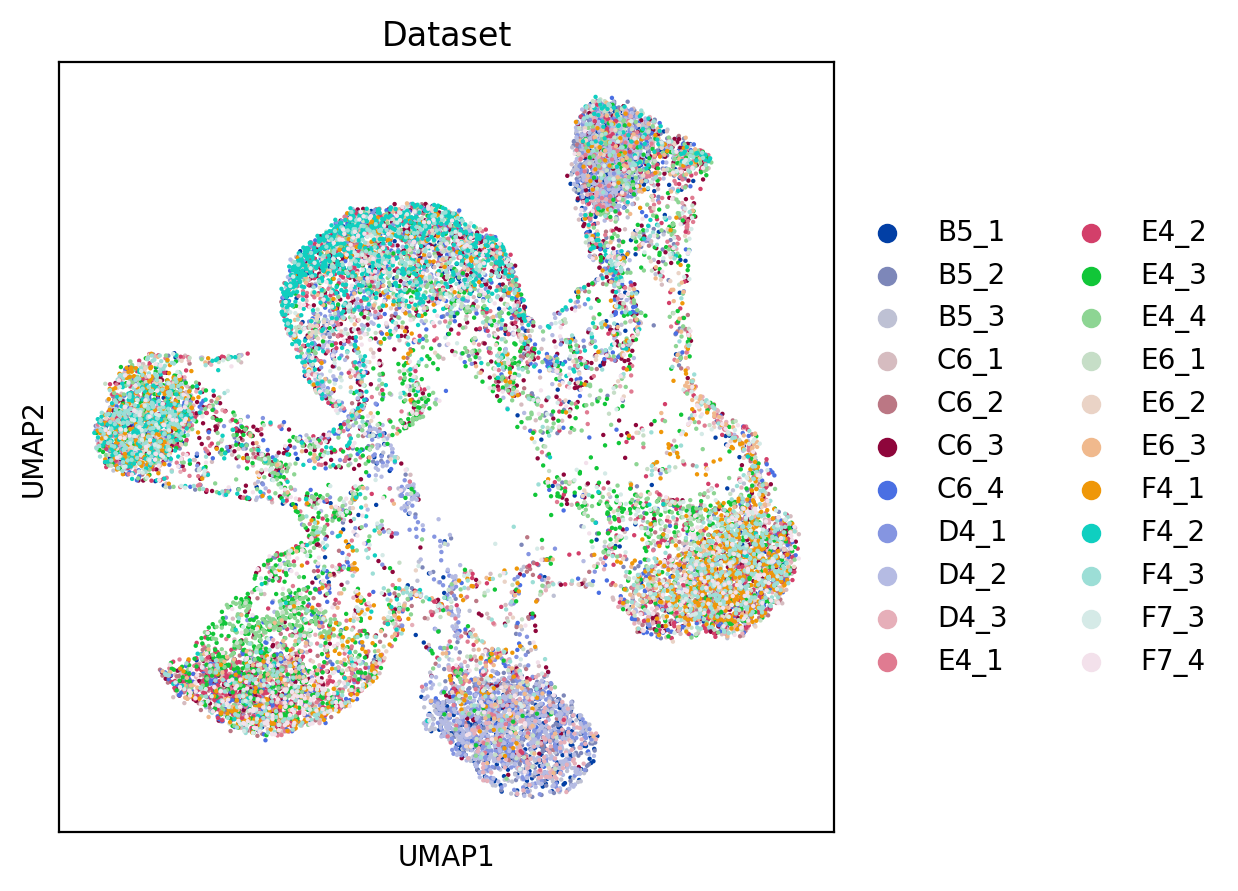

In [23]:
with rc_context({"figure.figsize": (5, 5), "figure.dpi": 200}):
    fig = sc.pl.umap(adata, color=["Dataset"], size=10)

C:\Users\thu71\Anaconda3\envs\scanpy\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


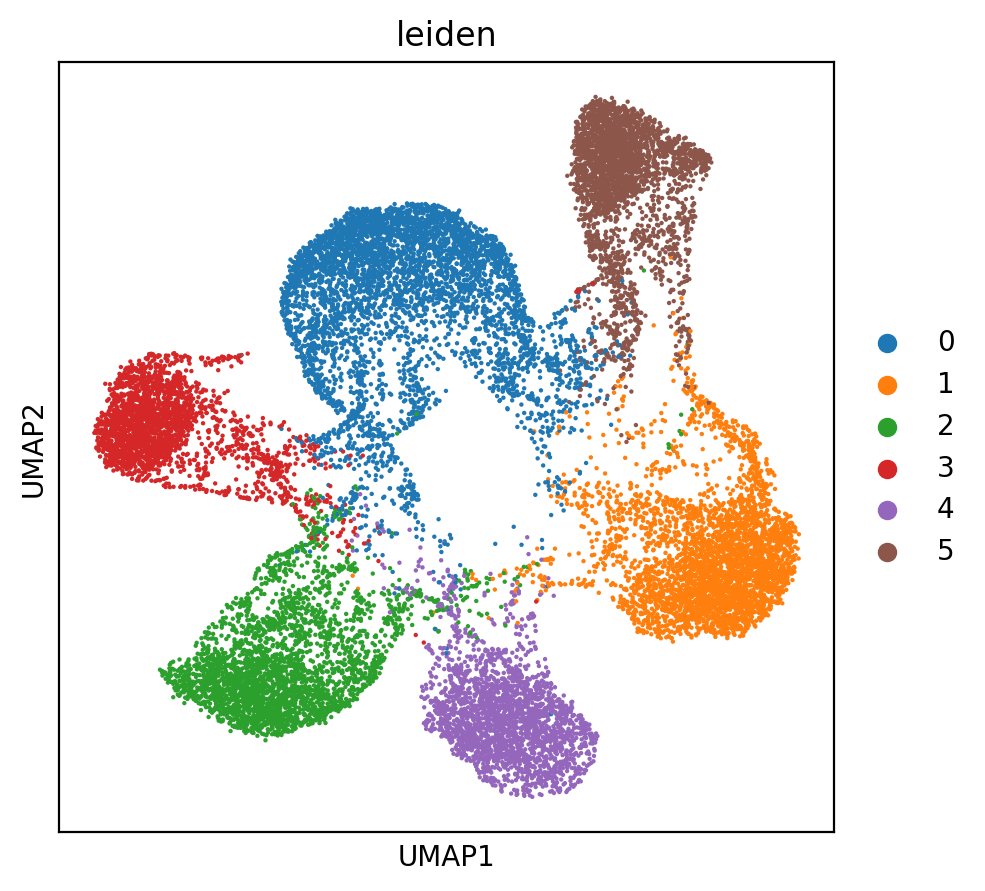

In [24]:
with rc_context({"figure.figsize": (5, 5), "figure.dpi": 200}):
    fig = sc.pl.umap(adata, color=["leiden"], size=10)

In [25]:
TSNE(adata,rep='Joint')

Using representation Joint
computing tSNE
    using sklearn.manifold.TSNE
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:48)
Sucessfully run TSNE!


AnnData object with n_obs × n_vars = 19507 × 197
    obs: 'Cell', 'Dataset', 'Core', 'leiden'
    uns: 'neighbors', 'umap', 'Dataset_colors', 'leiden_colors', 'tsne'
    obsm: 'spatial', 'Joint', 'X_umap', 'X_tsne'
    obsp: 'distances', 'connectivities'

C:\Users\thu71\Anaconda3\envs\scanpy\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


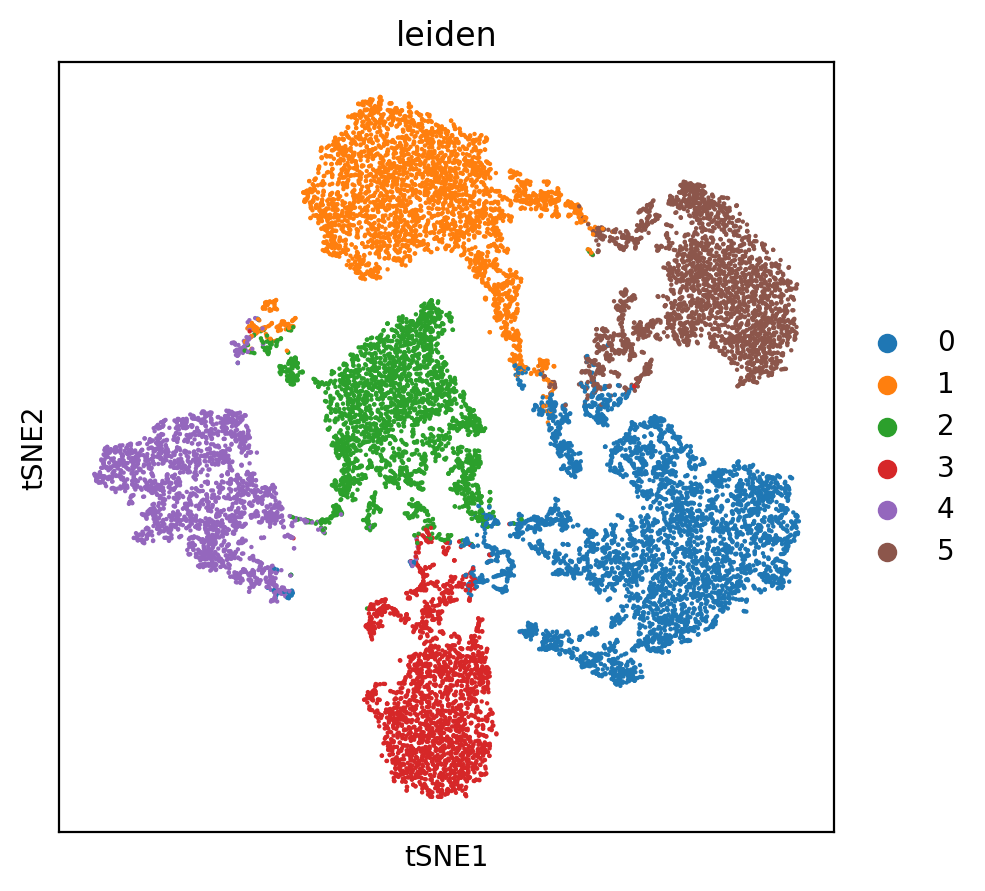

In [26]:
with rc_context({"figure.figsize": (5, 5), "figure.dpi": 200}):
    fig = sc.pl.tsne(adata, color=["leiden"], size=10)

In [27]:
sc.tl.rank_genes_groups(adata, groupby='leiden', method='t-test_overestim_var')


ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


C:\Users\thu71\Anaconda3\envs\scanpy\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
C:\Users\thu71\Anaconda3\envs\scanpy\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
C:\Users\thu71\Anaconda3\envs\scanpy\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
C:\Users\thu71\Anaconda3\envs\scanpy\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
C:\Users\thu71\Anaconda3\envs\scanpy\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
C:\Us

         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=50
    finished (0:00:00)
Storing dendrogram info using `.uns['dendrogram_leiden']`


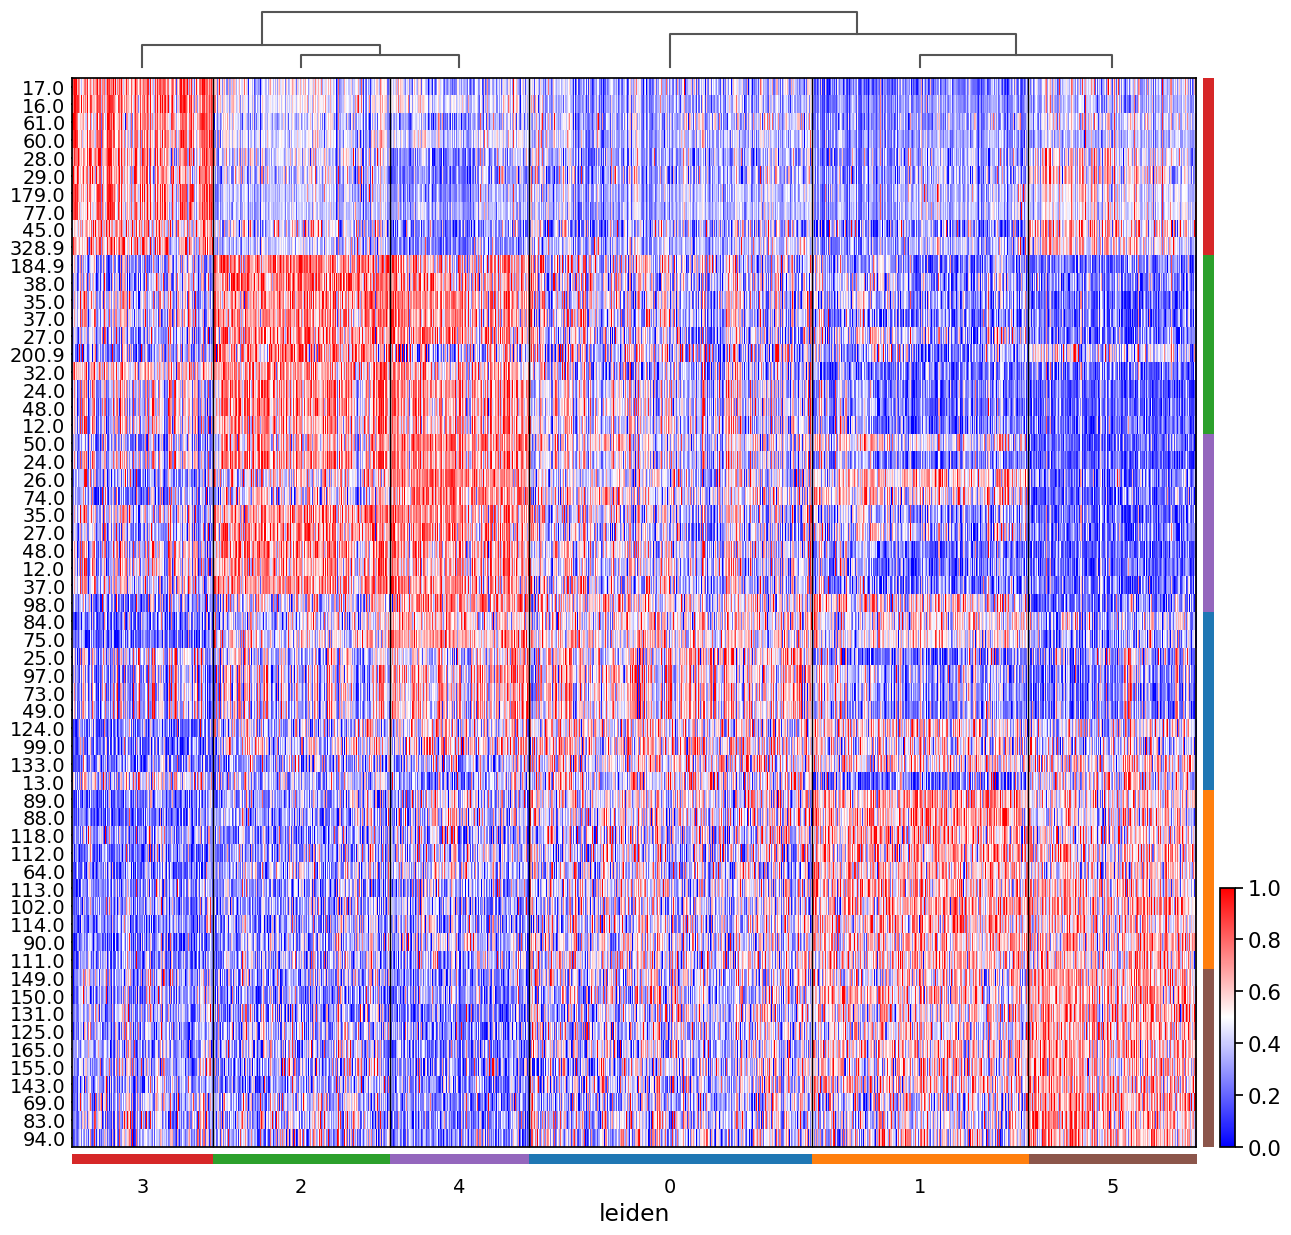

In [28]:
sns.set_context("notebook", font_scale=1.4)

dp_object =  sc.pl.rank_genes_groups_heatmap(adata, groupby='leiden', standard_scale='obs', cmap='bwr', 
                                             dendrogram=True, figsize=(15, 15), show_gene_labels=True, 
                                             swap_axes=True)

In [29]:
dedf = sc.get.rank_genes_groups_df(adata, group=None)
# Get top diff expression
topk=7
masses_largest = dedf.groupby('group').apply(lambda x: x.nlargest(topk,['scores'])).names.unique()
masses_lowest = dedf.groupby('group').apply(lambda x: x.nsmallest(topk,['scores'])).names.unique()
# masses = np.unique(np.concatenate([masses_largest, masses_lowest]))
masses = masses_largest

In [30]:
adata_subset = adata[:, masses]

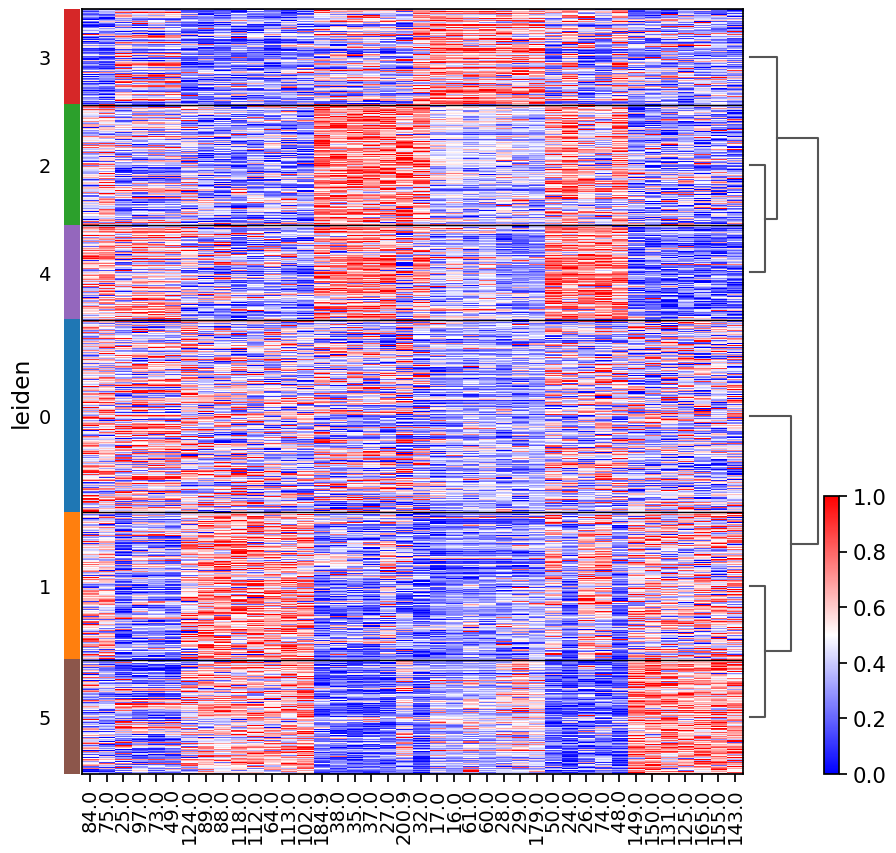

In [31]:
sc.pl.heatmap(
    adata_subset,
    adata_subset.var_names.tolist(),
    'leiden',
    dendrogram=True,
    cmap='bwr',
    figsize=(10, 10),
    standard_scale='obs',
    log=False,
    show_gene_labels=True
)



# Viz

In [32]:
adata_IMC.obs['leiden_joint'] = adata.obs['leiden']

C:\Users\thu71\AppData\Local\Temp\ipykernel_26104\2489695776.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_IMC.obs['leiden_joint'] = adata.obs['leiden']
C:\Users\thu71\Anaconda3\envs\scanpy\Lib\site-packages\anndata\_core\anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
C:\Users\thu71\Anaconda3\envs\scanpy\Lib\site-packages\anndata\_core\anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


    using data matrix X directly
Storing dendrogram info using `.uns['dendrogram_leiden_joint']`


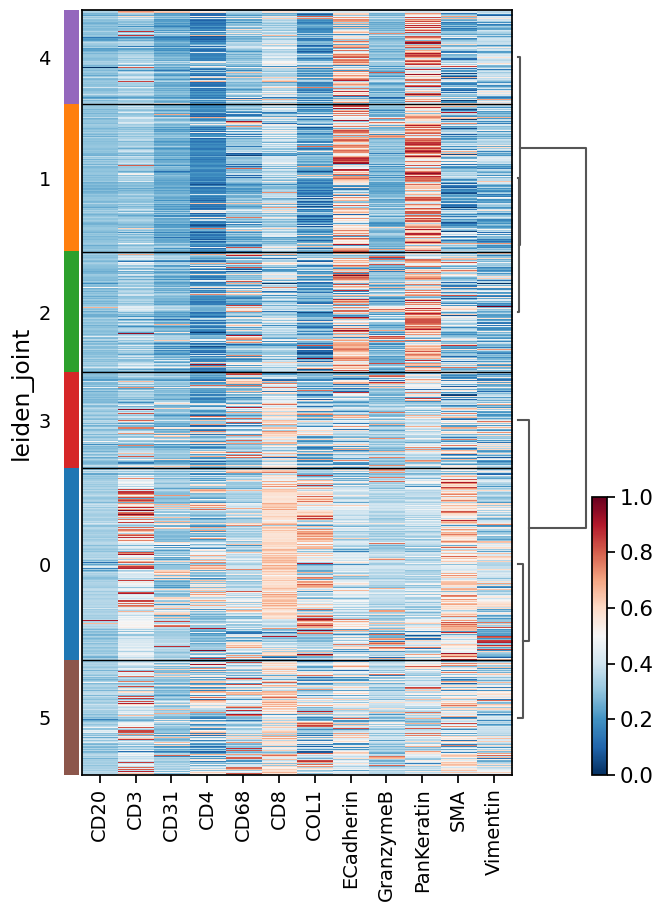

In [33]:
sc.tl.dendrogram(adata_IMC, 'leiden_joint')
sc.pl.heatmap(
    adata_IMC,
    adata_IMC.var_names.tolist(),
    'leiden_joint',
    dendrogram=True,
    cmap="RdBu_r",
    figsize=(7, 10),
    standard_scale='var'
)

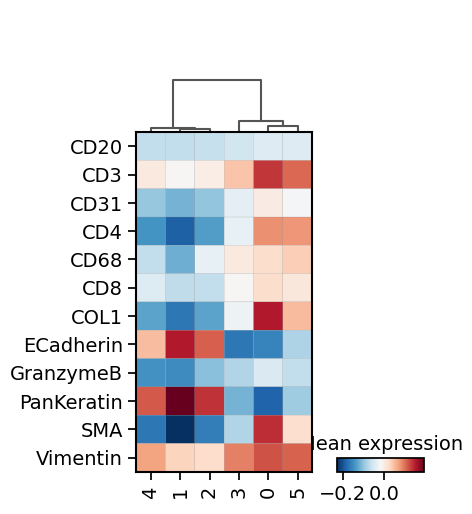

In [34]:
sc.pl.matrixplot(
    adata_IMC,
    adata_IMC.var_names.tolist(),
    'leiden_joint',
    dendrogram=True,
    colorbar_title="Mean expression",
    cmap="RdBu_r", 
    swap_axes=True,
)

C:\Users\thu71\Anaconda3\envs\scanpy\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


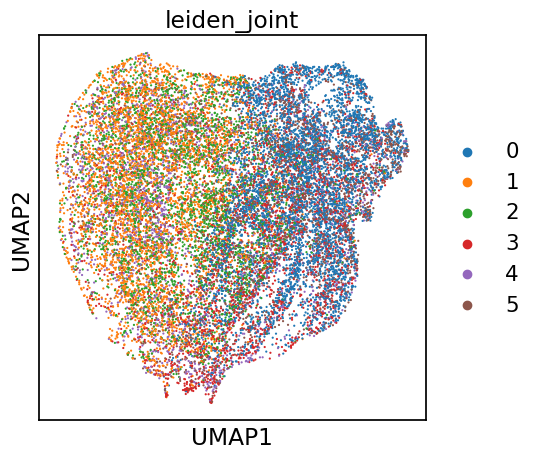

In [35]:

with rc_context({"figure.figsize": (5, 5), "figure.dpi": 100}):
    fig = sc.pl.umap(adata_IMC, color=['leiden_joint'], size=10)

In [36]:
import matplotlib 
cluster_label_order = adata_IMC.uns['dendrogram_leiden_joint']['categories_ordered']

colors = adata_IMC.uns["leiden_joint_colors"]
labels = adata_IMC.obs.leiden.cat.categories.tolist()

colors_rgb = []
for color in colors:
    colors_rgb.append(matplotlib.colors.hex2color(color))
colors_rgb = np.array(colors_rgb) * 255
colors_rgb = colors_rgb.astype(np.uint8)

colors_rgb_dict = {k:v for k,v in zip(labels, colors_rgb)}

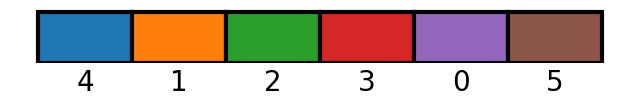

In [37]:
# legend
fig, ax = plt.subplots(figsize=(8,0.7))
ax.bar(x=range(len(colors_rgb_dict.values())), 
        color=np.array(list(colors_rgb_dict.values()))/255,
        width=1, 
        height=1,
        edgecolor='k',
        linewidth=3,
       )
_ = plt.xticks(range(len(colors_rgb_dict.values())), cluster_label_order, rotation=0, size=20)
_ = plt.yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.grid(False)
plt.show()

# Try clustering 

In [17]:
def grouped_obs_mean(adata, group_key, layer=None, gene_symbols=None):
    if layer is not None:
        getX = lambda x: x.layers[layer]
    else:
        getX = lambda x: x.X
    getX = lambda x: x.obsm['Joint']
    if gene_symbols is not None:
        new_idx = adata.var[idx]
    else:
        new_idx = adata.var_names

    grouped = adata.obs.groupby(group_key)
    out = pd.DataFrame(
        np.zeros((adata.obsm['Joint'].shape[1], len(grouped)), dtype=np.float64),
        columns=list(grouped.groups.keys()),
        # index=adata.var_names
    )

    for group, idx in grouped.indices.items():
        X = getX(adata[idx])
        out[group] = np.ravel(X.mean(axis=0, dtype=np.float64))
    return out

In [18]:
path = data_dir / 'joint' / f'{experiment}.h5ad' 
adata = ad.read_h5ad(path)

C:\Users\thu71\Anaconda3\envs\scanpy\Lib\site-packages\anndata\_core\anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [19]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, balanced_accuracy_score, f1_score

le = preprocessing.LabelEncoder()

In [20]:
sizes = [5, 10, 20, 40, 60, 100, 150, 200, 300]

scores = []
for block_size in sizes:
    # Extra block id per datasets
    spatial_block = (adata.obsm['spatial'] // block_size).astype(int)
    adata.obs['block'] = np.char.array(spatial_block[:,0].astype(str)) + '_' + np.char.array(spatial_block[:,1].astype(str))
    adata.obs['block'] = adata.obs['Dataset'].to_numpy()+ '_' +  adata.obs['block'].to_numpy()

    # Get mean representation
    df_mean = grouped_obs_mean(adata, 'block').T
    datasets = df_mean.index.str.split('_').str[0]
    y = le.fit_transform(datasets)

    # Train test split
    X_train, X_test, y_train, y_test = train_test_split(
            df_mean, y, test_size=0.4, random_state=42
        )

    # Classifier
    clf = AdaBoostClassifier()
    clf = make_pipeline(StandardScaler(), clf)
    clf.fit(X_train, y_train)
    y_pred = np.argmax(clf.predict_proba(X_test), axis=1)
    scores.append([roc_auc_score(y_test, clf.predict_proba(X_test), multi_class='ovr'), 
                  f1_score(y_test, y_pred, average='weighted'), 
                  balanced_accuracy_score(y_test, y_pred)
                  ])

ValueError: y should be a 1d array, got an array of shape (10072, 2) instead.

In [143]:
df = pd.DataFrame(scores,index=sizes, columns=['AUC', 'F1', 'Accuracy']).T

In [144]:
df

,5,10,20,40,60,100,150,200,300
AUC,0.667627,0.680412,0.693752,0.646151,0.691383,0.658720,0.600005,0.568826,0.448590
F1,0.338084,0.355722,0.344926,0.334454,0.381699,0.231461,0.256255,0.088745,0.206316
Accuracy,0.290158,0.308337,0.304063,0.294866,0.342306,0.203194,0.216850,0.191558,0.214286


In [146]:
df.to_clipboard()